<img src = 'africa.jpg'><img>

<span>Photo by <a href="https://unsplash.com/@huchenme?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Hu Chen</a> on <a href="https://unsplash.com/s/photos/africa?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

# Financial Inclusion in Africa

O objetivo deste documento é realizar a análise dos dados e um modelo preditivo para predizer se uma pessoa tem ou não tem uma conta bancária utilizando as informações de inclusão financeira na África.

De acordo com as instruções enviadas pela <b>Agibank</b> :

(...)<i>Você deve trabalhar com os arquivos Train_v2.csv e VariableDefinitions.csv pra fazer um
relatório. A análise de dados a ser conduzida buscará predizer se uma pessoa tem ou não tem
uma conta bancária na África (variável resposta "bank_account"). A análise deverá englobar
importação da base, exploração descritiva e modelagem.</i>

## Financial Inclusion Survey Data

De acordo com o site que disponibiliza o conjunto de dados, <a href = 'https://zindi.africa/competitions/financial-inclusion-in-africa/data'> Zindi</a>, o dataset principal contém informações demográficas e quais serviços financeiros são utilizados por aproximadamente 33.160 pessoas na África Oriental. Os dados foram extraídos de pesquisas nos anos de 2016 até 2018.

O dataset principal é divido em dois datasets: um de **treino** e outro para **testes** dos modelos.

In [1]:
ver = !python --version
print("Versão do python: " + str(ver))

Versão do python: ['Python 3.7.6']


In [2]:
#importando bibliotecas
import pandas as pd
import numpy as np
import missingno as mn
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, plot_confusion_matrix)
import sklearn.metrics as metrics
%matplotlib inline

# setting up plot style 
style.use('seaborn-poster')
style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_colwidth = 500

In [3]:
#importando datasets
df_variaveis = pd.read_csv("VariableDefinitions.csv")
df = pd.read_csv("Train_v2.csv")

In [4]:
#conferindo
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
#dicionário do dataset:
df_variaveis

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,"The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know"
9,marital_status,"The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know"


## Data Wrangling e Data Cleaning

In [6]:
#fazendo uma cópia do dataset original

df_copy = df.copy()
df_copy.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


Primeiro vamos conferir algumas informações do dataset:

In [7]:
print("O dataset possui %s linhas e %s colunas." % (df_copy.shape[0], df_copy.shape[1]))

O dataset possui 23524 linhas e 13 colunas.


In [8]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Podemos observar acima que não temos dados faltantes nesse dataset. Podemos utilizar a biblioteca **missingno** para analisarmos esta questão atraves de um gráfico. Vejamos:

<AxesSubplot:>

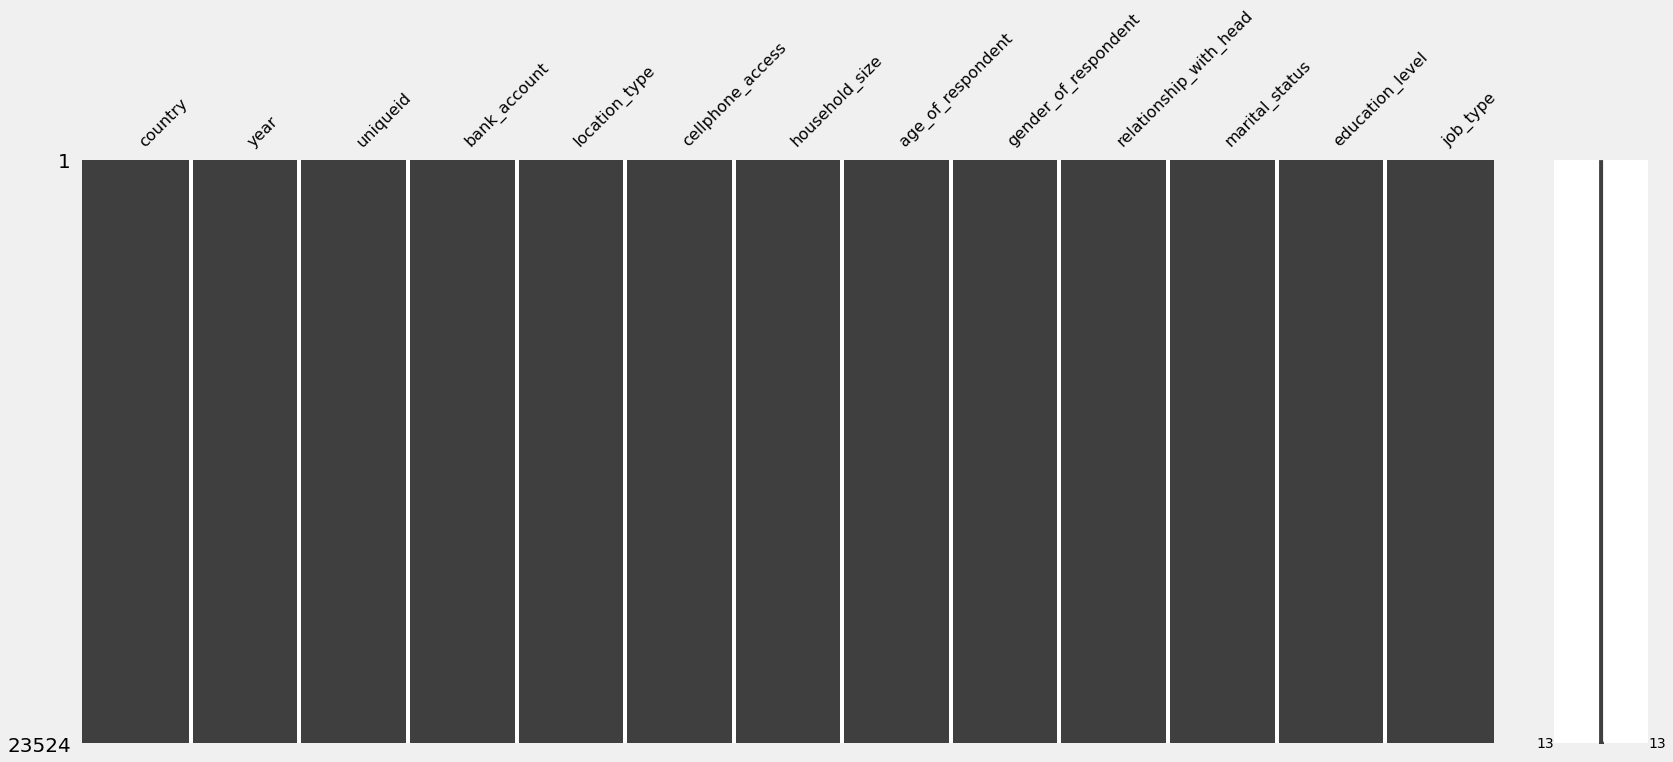

In [9]:
mn.matrix(df_copy)

### Campo uniqueid:

De acordo com a descrição das variáveis no site, o campo `uniqueid` representa a chave única do indivíduo no próprio país. Isso quer dizer que podemos ter o mesmo valor de `uniqueid` mas com países distintios. Para que este campo realmente represente uma chave única em nosso dataset, vamos unir com o a coluna `country`.

Dessa forma a coluna teremos o valor da chave única no seguinte formato: "uniqueid_x + country name"

In [10]:
#verificando:
df_copy[['uniqueid', 'country']].groupby('uniqueid').count()

,country
uniqueid,
uniqueid_1,4
uniqueid_10,4
uniqueid_100,4
uniqueid_1000,4
uniqueid_1001,4
...,...
uniqueid_995,4
uniqueid_996,4
uniqueid_997,4


**Code**

In [11]:
df_copy['uniqueid'] = df_copy['uniqueid'] + df_copy['country']

**Test**

In [12]:
df_copy.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1Kenya,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2Kenya,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3Kenya,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4Kenya,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5Kenya,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Análise Exploratória dos Dados

Vejamos um resumo estatítstico das variáveis quantitativas:

In [13]:
df_copy.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


Rapidamente podemos observar alguns pontos:
- a idade média é de aporixmadamente 39 anos;
- os extremos mínimo e máximo são 16 anos e 100 anos respectivamente;
- o desvio padrão é de 16,5 anos, um número consideravelmente alto;
- o número médio de indivíduos em uma casa é de aproximadamente 4 pessoas; com desvio padrão de 2,2.
- o número máximo de indivíduos em uma casa é de 21 pessoas. Provavelmente trata-se de um outlier.

#### Distribuição da idade

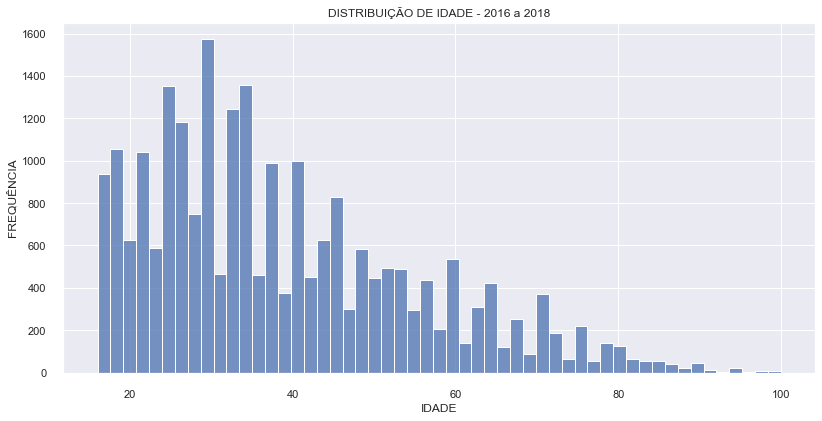

In [14]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.histplot(x="age_of_respondent", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DE IDADE - 2016 a 2018',ylabel = 'FREQUÊNCIA', xlabel = 'IDADE')
plt.show()

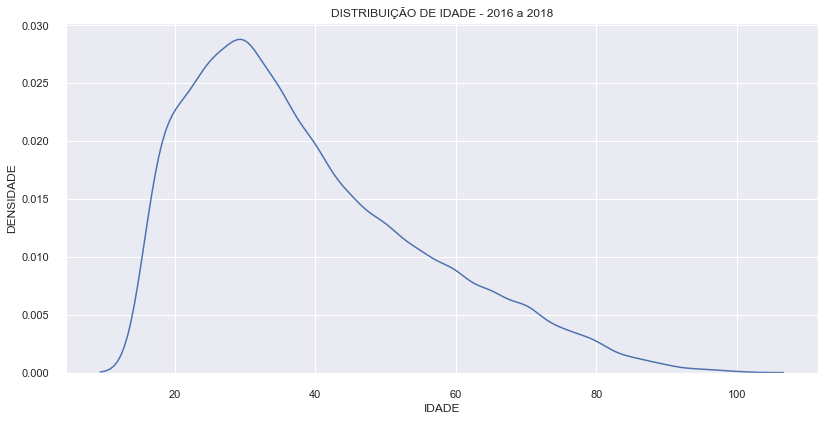

In [15]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.kdeplot(x="age_of_respondent", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DE IDADE - 2016 a 2018',ylabel = 'DENSIDADE', xlabel = 'IDADE')
plt.show()

A distribuição da idade apresenta uma curva assimetrica à direita. Em distribições desse tipo temos a maioria dos valores concentrados abaixo do média; esta por sua vez é maior do que a mediana.

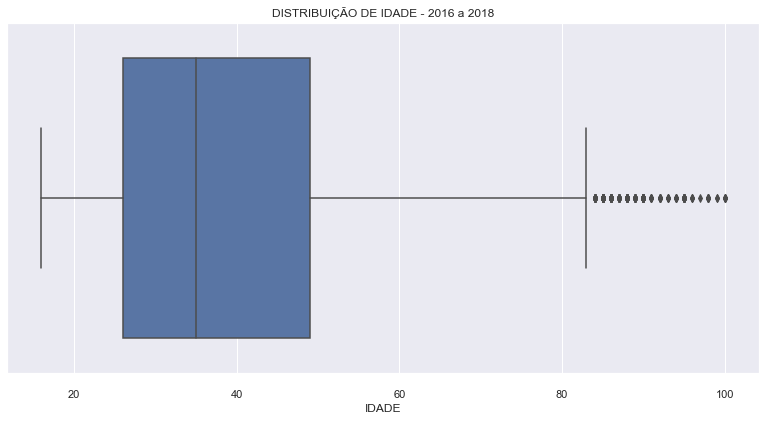

In [16]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.boxplot(x="age_of_respondent", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DE IDADE - 2016 a 2018', xlabel = 'IDADE')
plt.show()

**Distribuição do tamanhao da família**

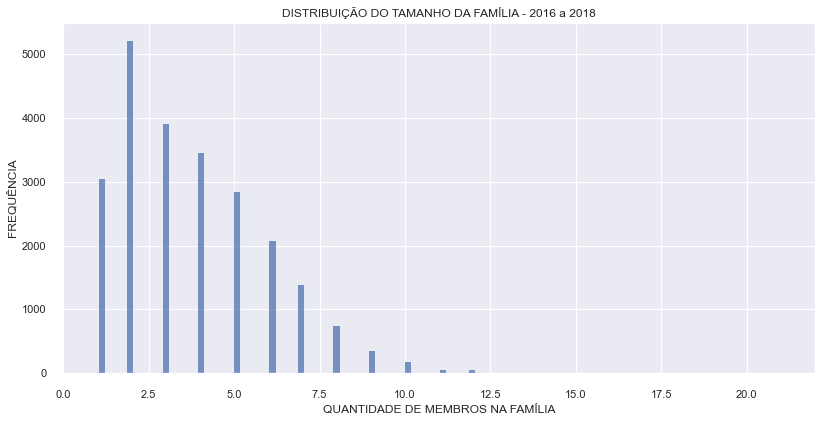

In [17]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.histplot(x="household_size", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DO TAMANHO DA FAMÍLIA - 2016 a 2018',ylabel = 'FREQUÊNCIA',
       xlabel = 'QUANTIDADE DE MEMBROS NA FAMÍLIA')
plt.show()

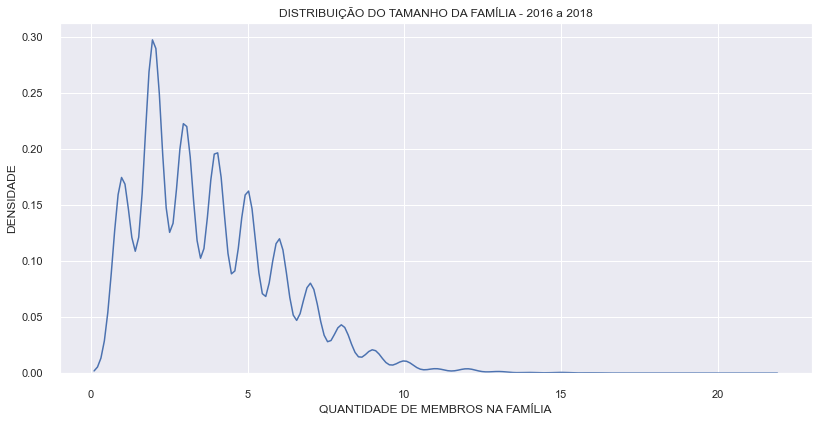

In [18]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.kdeplot(x="household_size", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DO TAMANHO DA FAMÍLIA - 2016 a 2018',ylabel = 'DENSIDADE',
       xlabel = 'QUANTIDADE DE MEMBROS NA FAMÍLIA')
plt.show()

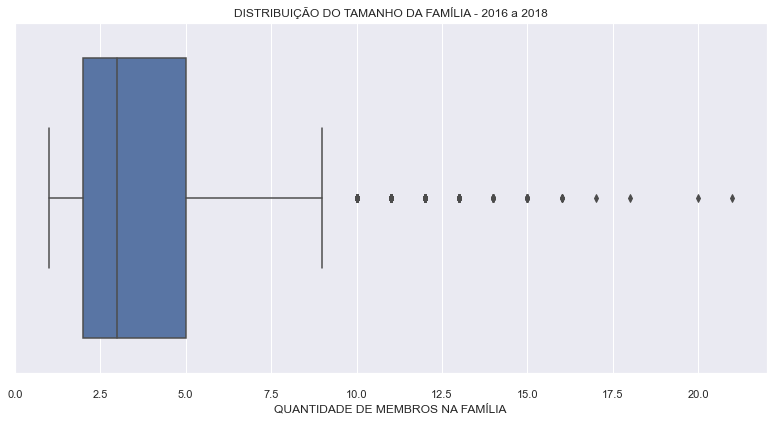

In [19]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.boxplot(x="household_size", data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DO TAMANHO DA FAMÍLIA - 2016 a 2018', xlabel = 'QUANTIDADE DE MEMBROS NA FAMÍLIA')
plt.show()

A distribição nesse caso também é assimétrica eniesada à direita, da mesma forma que a idade. Vejamos se há uma correlação entre ambas.

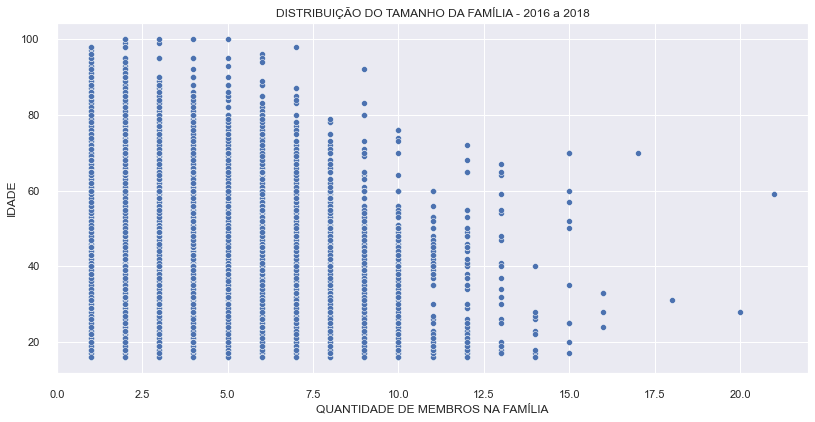

In [20]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.scatterplot(x="household_size", y = 'age_of_respondent', data = df_copy)
ax.set(title = 'DISTRIBUIÇÃO DO TAMANHO DA FAMÍLIA - 2016 a 2018', 
       xlabel = 'QUANTIDADE DE MEMBROS NA FAMÍLIA', ylabel = 'IDADE')
plt.show()

In [21]:
#coeficiente de Pearson:
df['household_size'].corr(df['age_of_respondent'])

-0.12972914326105414

De acordo com o coeficiente de <a href = 'https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson'> Pearson</a>, bem como o comportamento do gráfico das duas variáveis, podemos concluir que não há correlação entre as duas variáveis.

### Análise Demográfica

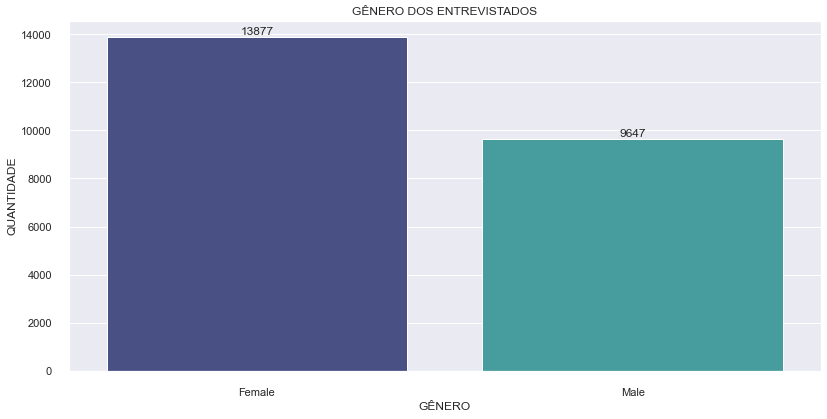

In [22]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'gender_of_respondent', data = df_copy, palette= "mako")
ax.set(title = "GÊNERO DOS ENTREVISTADOS", xlabel = "GÊNERO", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

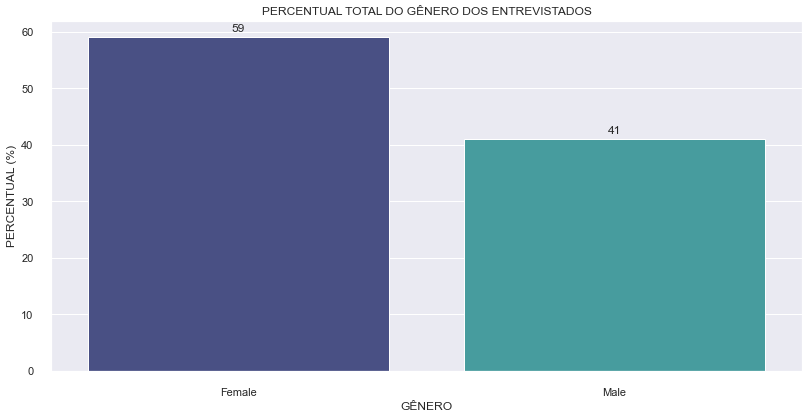

In [23]:
#percentual homens x mulheres:
temp = df_copy['gender_of_respondent'].value_counts().reset_index()
temp['percent'] = round((temp['gender_of_respondent']/sum(temp['gender_of_respondent'])*100))

sns.set(rc={'figure.figsize': (12,6)})
ax = sns.barplot(x = 'index', y = "percent", data = temp, palette= "mako")
ax.set(title = "PERCENTUAL TOTAL DO GÊNERO DOS ENTREVISTADOS", xlabel = "GÊNERO", ylabel = 'PERCENTUAL (%)' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+1,
    s = '{:.0f}'.format(height),
    ha = 'center')

plt.show()
#temp

Mais mulheres foram entrevistadas do que homens de acordo com os dados coletados, com 59% e 41% respectivamente.
Vejamos como se dá a distribuição de gênero por países

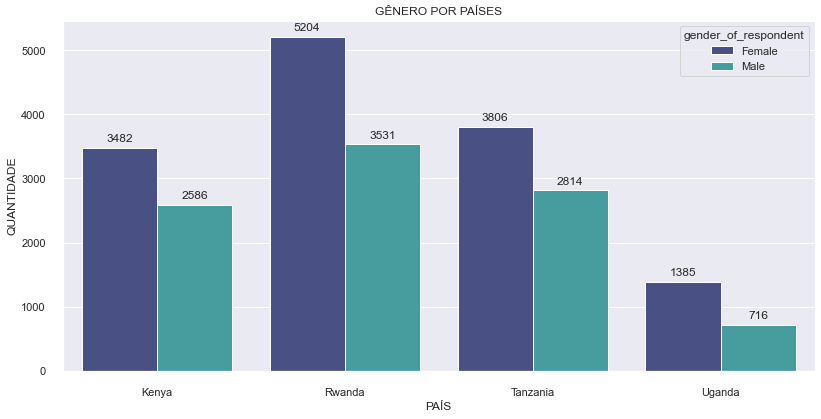

In [24]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'country', hue = 'gender_of_respondent', data = df_copy, palette= "mako")
ax.set(title = "GÊNERO POR PAÍSES", xlabel = "PAÍS", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

Em todos os quatro países a quantidade de mulheres é maior que a de homens.
Vejamos agora o tipo de localização.

**Tipo de Localização**

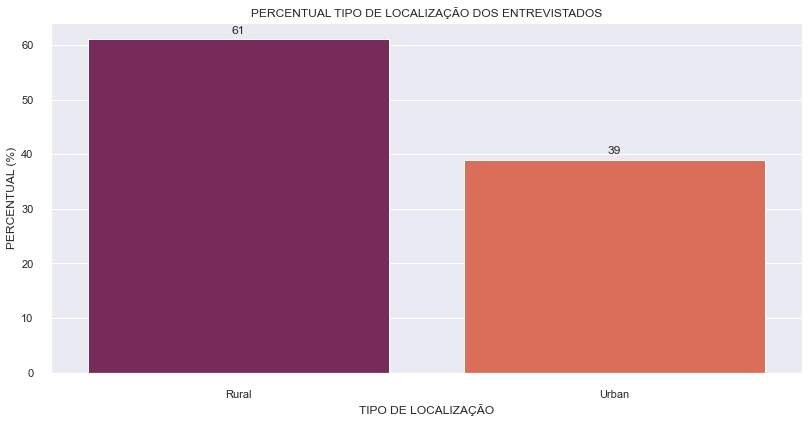

In [25]:
temp = df_copy['location_type'].value_counts().reset_index()
temp['percent'] = round((temp['location_type']/sum(temp['location_type']))*100)

sns.set(rc={'figure.figsize': (12,6)})
ax = sns.barplot(x = 'index', y = "percent", data = temp, palette= "rocket")
ax.set(title = "PERCENTUAL TIPO DE LOCALIZAÇÃO DOS ENTREVISTADOS", xlabel = "TIPO DE LOCALIZAÇÃO",
       ylabel = 'PERCENTUAL (%)' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+1,
    s = '{:.0f}'.format(height),
    ha = 'center')

plt.show()

61% dos entrevistados vivem na área rural. Vejamos essa distribuição por países:

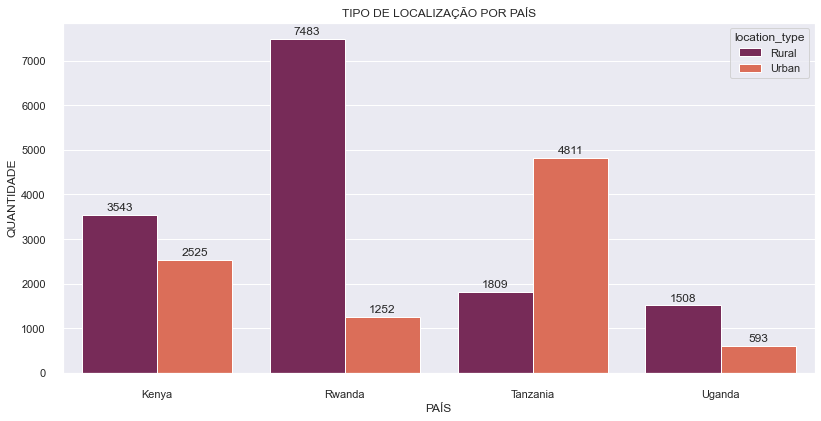

In [26]:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'country', hue = 'location_type', data = df_copy, palette= "rocket")
ax.set(title = "TIPO DE LOCALIZAÇÃO POR PAÍS", xlabel = "PAÍS", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

A Tanzania possui a grande maioria dos indivíduos localizados na área rural. A Tanzânia é o único país onde a população urbana é maior do que a rural.

**Faixa Etária**

Vamos criar um dicionário para segmentar a faixa etária das pessoas de acordo com a <a href = 'https://pt.wikipedia.org/wiki/Predefini%C3%A7%C3%A3o:Faixas_et%C3%A1rias_do_Brasil'>Predefinição de faixas etárias no Brasil</a>.

- Criança (child): 0 a 14 anos;
- Jovem (young): 15 a 24 anos;
- Adulto (adult): 25 a 64 anos;
- Idoso (eldery): a partir de 65 anos;

In [27]:
#função para criar os valores da faixa etária
def idade(row):
    '''
    Função que vai passar pelas linhas do dataframe, coletar
    a idade correspondente e aplicar a segmentação correspondente
    '''
    if(row['age_of_respondent'] < 15):
        val = 'child'
    elif(row['age_of_respondent'] < 25):
        val = 'young'
    elif(row['age_of_respondent'] < 65):
        val = 'adult'
    else:
        val = 'elderly'
    return val

In [28]:
#criando a nova coluna no dataframe
df_copy['age_group'] = df_copy.apply(idade, axis=1)

#conferindo:
df_copy.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group
0,Kenya,2018,uniqueid_1Kenya,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,young
1,Kenya,2018,uniqueid_2Kenya,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,elderly
2,Kenya,2018,uniqueid_3Kenya,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,adult
3,Kenya,2018,uniqueid_4Kenya,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,adult
4,Kenya,2018,uniqueid_5Kenya,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,adult


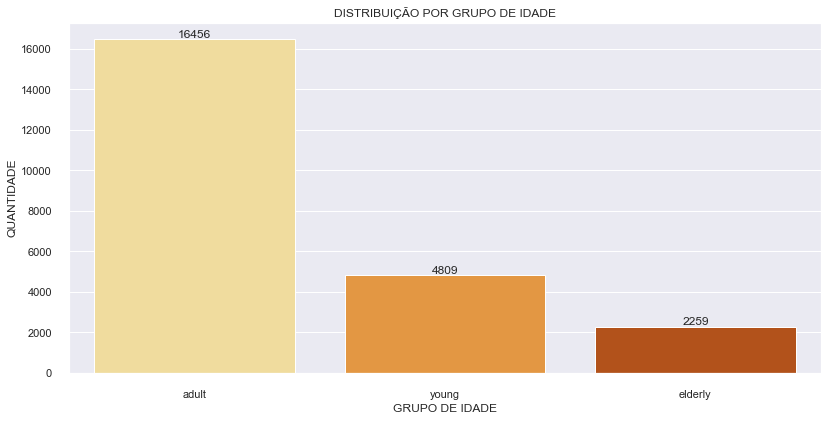

In [29]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'age_group', data = df_copy, palette= "YlOrBr", order = df_copy['age_group'].value_counts().index)
ax.set(title = "DISTRIBUIÇÃO POR GRUPO DE IDADE", xlabel = "GRUPO DE IDADE", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')


A esmagadora maioria dos indivíduos são adultos (idade entre 25 a 64 anos). Vamos ver agora como seria essa segmentação de acordo com os países, assim podemos verificar se há um país mais jovem ou mais velho do que outro.

**País**

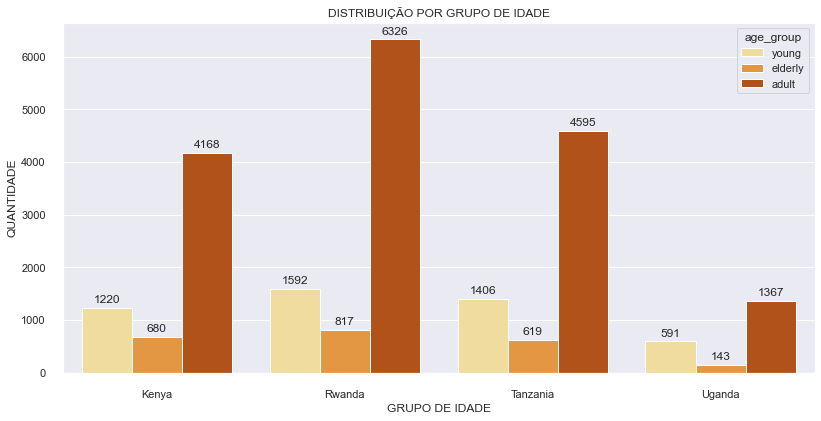

In [30]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'country', data = df_copy, hue = 'age_group', palette= "YlOrBr")
ax.set(title = "DISTRIBUIÇÃO POR GRUPO DE IDADE", xlabel = "GRUPO DE IDADE", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

Os países apresentam uma distribuição semelhante entre eles, com os adultos sendo a maoiria, seguido por pessoas jovens e por fim os idosos.

### Bancarização

Vamos agora analisar a assoiação das variáveis quantitativas e qualitativas em relação a variável de bancarização, vairável esta que indica se o indivíduo possui conta bancária ou não.

**Distribuição total**

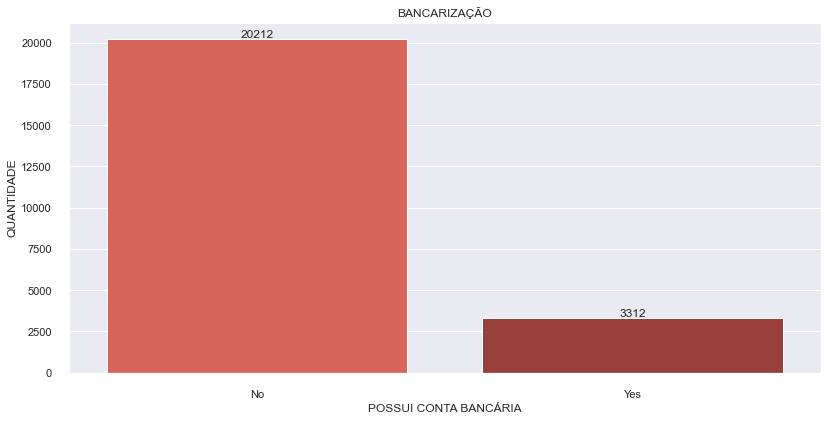

In [31]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'bank_account', data = df_copy, palette= "Reds_d", 
                   order = df_copy['bank_account'].value_counts().index)
ax.set(title = "BANCARIZAÇÃO", xlabel = "POSSUI CONTA BANCÁRIA", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

In [32]:
#dataframe do percentual
temp = df_copy['bank_account'].value_counts().reset_index()
temp['percent'] = round((temp['bank_account']/sum(temp['bank_account']))*100)
temp

,index,bank_account,percent
0,No,20212,86.0
1,Yes,3312,14.0


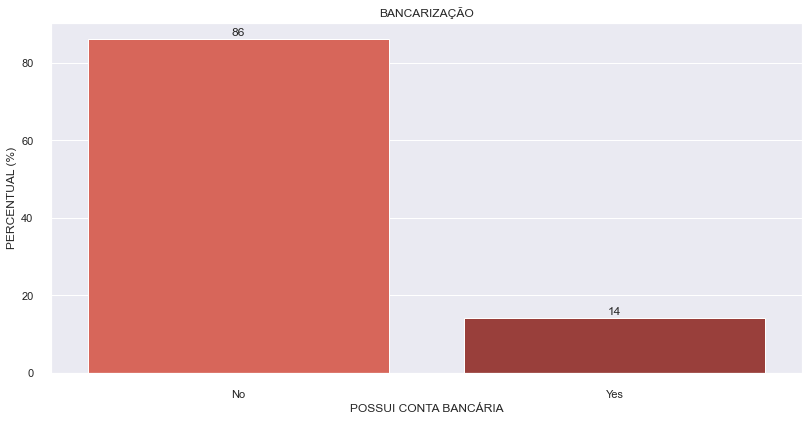

In [33]:
#plotando gráfico percentual:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.barplot(x = 'index', y  = 'percent', data = temp, palette= "Reds_d")
ax.set(title = "BANCARIZAÇÃO", xlabel = "POSSUI CONTA BANCÁRIA", ylabel = 'PERCENTUAL (%)' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+1,
    s = '{:.0f}'.format(height),
    ha = 'center')

86% dos indivíduos não possuem conta bancária. A diferença é muito grande.

**Gênero**

Vimos anteriormente que 59% dos indivíduos entevistados são mulheres. Vejamos agora como se dá a bancarização por sexo:

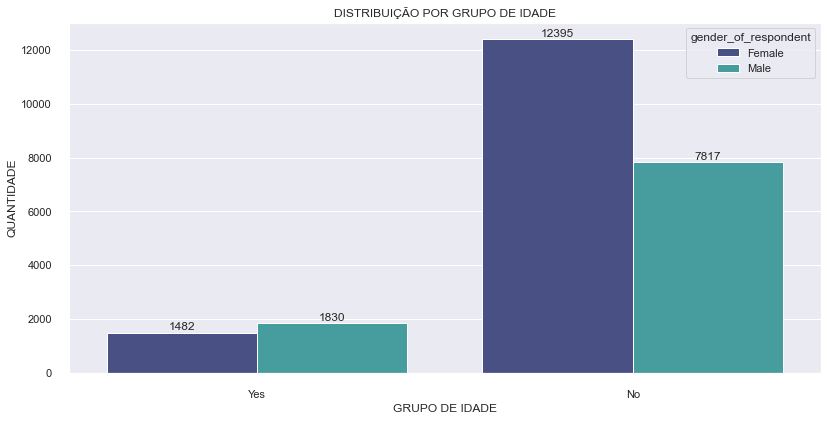

In [34]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'bank_account', data = df_copy, hue = 'gender_of_respondent', palette= "mako")
ax.set(title = "DISTRIBUIÇÃO POR GRUPO DE IDADE", xlabel = "GRUPO DE IDADE", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

Dos indivíduos bancarizados, os homens se seboressaem sobre as mulheres, ainda que com pouca vantagem. Já nos indivíduos que não possuem conta bancária, as mulheres são a grande maioria. Vale lembrar que as mulheres são a maioria dos entrevistados. 

**Localização**

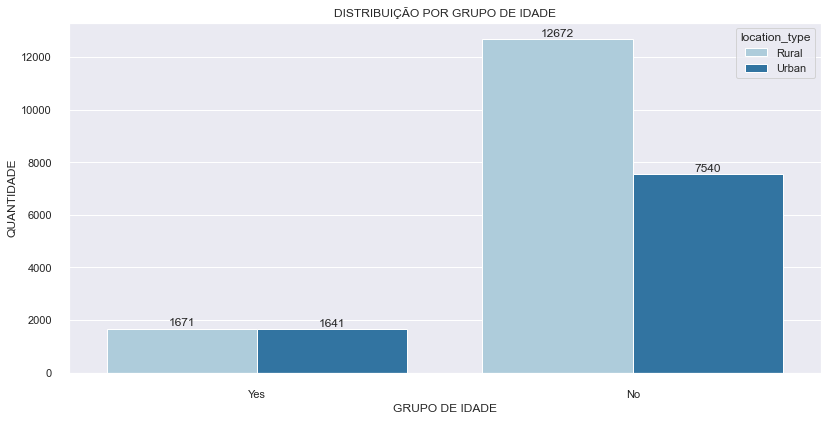

In [35]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'bank_account', data = df_copy, hue = 'location_type', palette= "Paired")
ax.set(title = "DISTRIBUIÇÃO POR GRUPO DE IDADE", xlabel = "GRUPO DE IDADE", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

A maioria das pessoas que não possuem conta bancária encontram-se na zona rural. O Curioso é que as pessoas que possuem conta bancária estão divididas igualmente entre zona rural e urbana.

**País**

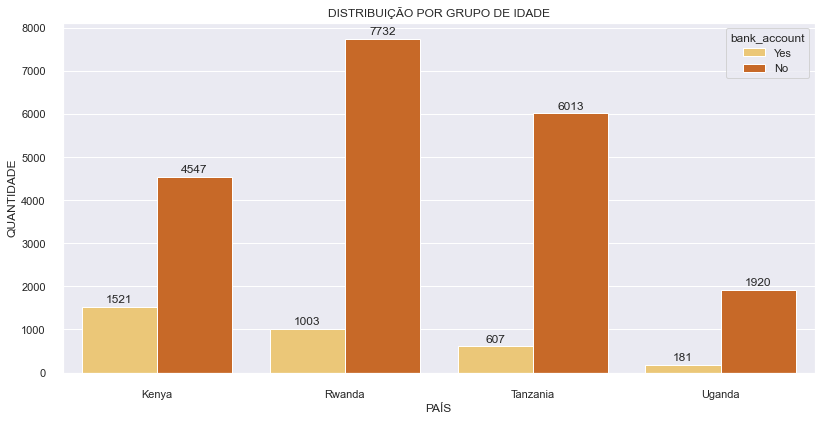

In [36]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'country', data = df_copy, hue = 'bank_account', palette= "YlOrBr")
ax.set(title = "DISTRIBUIÇÃO POR GRUPO DE IDADE", xlabel = "PAÍS", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

Quênia é o país que paresenta uma maior taxa de bancarização em comparação com os outros países. Ruanda, o país mais populoso, possui uma grande diferença de pessoas bancarizadas frente as não bancarizadas.
Vale recordar que Ruanda possui uma população majoriatariamente Rural, e a distribuição de pessoas que não possuem conta bancária se concentram na região rural em sua maioria.

**Faixa Etária**

Vejamos primeiro a distribuição de idade dos que possuem conta bancária:

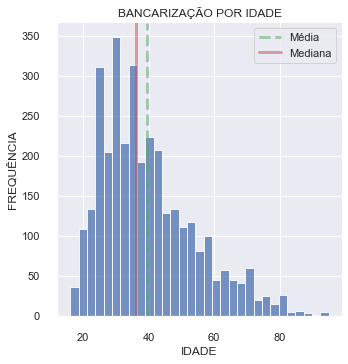

In [37]:
temp = df_copy[df_copy['bank_account'] == 'Yes']  #datarframe somente com quem possi conta bancaria

#sns.set(rc={'figure.figsize': (12,6)})
ax = sns.displot(data = temp['age_of_respondent'], kde= False)
mean = plt.axvline(x=temp['age_of_respondent'].mean(), linewidth=3, color='g', label="mean", alpha=0.5, linestyle='--')
median = plt.axvline(x=temp['age_of_respondent'].median(), linewidth=3, color='r', label="median", alpha=0.5,
                     linestyle='-')

ax.set(title = "BANCARIZAÇÃO POR IDADE", xlabel = "IDADE", ylabel = 'FREQUÊNCIA')
plt.legend({'Média':mean,'Mediana':median})
plt.show()

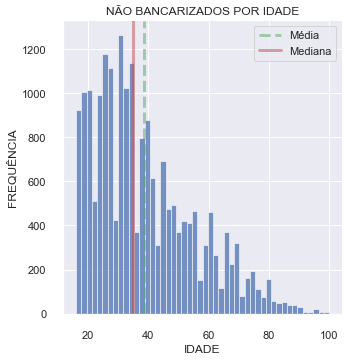

In [38]:
temp = df_copy[df_copy['bank_account'] == 'No']  #datarframe somente de quem não possi conta bancária

#sns.set(rc={'figure.figsize': (12,6)})
ax = sns.displot(data = temp['age_of_respondent'], kde= False)
mean = plt.axvline(x=temp['age_of_respondent'].mean(), linewidth=3, color='g', label="mean", alpha=0.5, linestyle='--')
median = plt.axvline(x=temp['age_of_respondent'].median(), linewidth=3, color='r', label="median", alpha=0.5,
                     linestyle='-')

ax.set(title = "NÃO BANCARIZADOS POR IDADE", xlabel = "IDADE", ylabel = 'FREQUÊNCIA')
plt.legend({'Média':mean,'Mediana':median})
plt.show()

Os dois grupos possuem uma distribuição semelhante, enviesada à direita. Boa parte dos bancarizados se concentram em adultos. Vamos verificar se esta afirmação procede em outro gráfico.

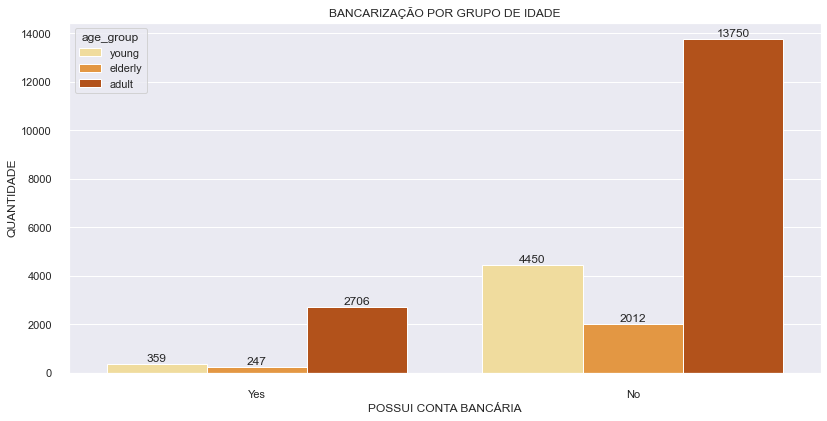

In [39]:
#plotando gráfico:
sns.set(rc={'figure.figsize': (12,6)})
ax = sns.countplot(x = 'bank_account', data = df_copy, hue = 'age_group',
                   palette= "YlOrBr")##, order = df_copy['age_group'].value_counts().index)
ax.set(title = "BANCARIZAÇÃO POR GRUPO DE IDADE", xlabel = "POSSUI CONTA BANCÁRIA", ylabel = 'QUANTIDADE' )

#adicionando labels acima das barras
for p in ax.patches:
    height = p.get_height() #altura das barras
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+100,
    s = '{:.0f}'.format(height),
    ha = 'center')

Como esperado, a maioria dos bancarizados são adultos, seguido de jovens.

# Preprocessing

Vamos iniciar a preparação dos dados para construção dos modelos preditivos.

In [40]:
df_copy.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group
0,Kenya,2018,uniqueid_1Kenya,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,young
1,Kenya,2018,uniqueid_2Kenya,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,elderly
2,Kenya,2018,uniqueid_3Kenya,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,adult
3,Kenya,2018,uniqueid_4Kenya,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,adult
4,Kenya,2018,uniqueid_5Kenya,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,adult


**removendo colunas**

A feature `uniqueid` não possui relevância para nossos modelos, uma vez que ela é a identificação única do indivíduo para nosso conjunto de dados.

A feature `age_of_respondent` também será excluída, uma vez que criamos a coluna `age_group` para agrupar a faixa etária.


In [41]:
#dropando colunas

df_copy.drop(columns = ['uniqueid', 'age_of_respondent'], inplace = True)
df_copy.head()

,country,year,bank_account,location_type,cellphone_access,household_size,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group
0,Kenya,2018,Yes,Rural,Yes,3,Female,Spouse,Married/Living together,Secondary education,Self employed,young
1,Kenya,2018,No,Rural,No,5,Female,Head of Household,Widowed,No formal education,Government Dependent,elderly
2,Kenya,2018,Yes,Urban,Yes,5,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,adult
3,Kenya,2018,No,Rural,Yes,5,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,adult
4,Kenya,2018,No,Urban,No,8,Male,Child,Single/Never Married,Primary education,Informally employed,adult


## Transforming Categorical Values
Vamos transformar nossas variáveis categóricas em variáveis numéricas para utilizar em nossos modelos.

- **variável dependente**: também conhecida como **variável resposta**, **y** ou **label**; é a resposta que estamos tentando prever no nosso problema. No nosso caso é a coluna `bank_account`, que identifica se o indivíduo possui ou não conta bancária;
- **variável independente**: também conhecida como **X** ou **feature**, são as variáveis que nos fornecem características e informações sobre as observações, e que são utilizadas nos modelos para construir o algoritmo que irá predizer a variável resposta. 

Desse modo, vamos primeiro separar as variáveis dependentes das independentes.


In [42]:
#separando as variáveis
X = df_copy.drop('bank_account', axis = 1)
y = df_copy['bank_account']

In [43]:
#conferindo
X.head()

,country,year,location_type,cellphone_access,household_size,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_group
0,Kenya,2018,Rural,Yes,3,Female,Spouse,Married/Living together,Secondary education,Self employed,young
1,Kenya,2018,Rural,No,5,Female,Head of Household,Widowed,No formal education,Government Dependent,elderly
2,Kenya,2018,Urban,Yes,5,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,adult
3,Kenya,2018,Rural,Yes,5,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,adult
4,Kenya,2018,Urban,No,8,Male,Child,Single/Never Married,Primary education,Informally employed,adult


In [44]:
y.head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: bank_account, dtype: object

Primeiro vamos transformar as variáveis independentes (*features*).

**Encoding independent variables**

In [45]:
#lista das variáveis categóricas
datatype = X.dtypes
object_cols = datatype[(datatype == 'object') | (datatype == 'category')].index.tolist()

print("Categorical variables:")
print(object_cols)

Categorical variables:
['country', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type', 'age_group']


In [46]:
#get dummies
dummy = pd.get_dummies(X[object_cols], drop_first=True)

#concatenando dataframes
X = pd.concat([X, dummy], axis = 1)

#drop the columns:
X.drop(columns = object_cols, axis= 1, inplace = True)

#conferindo
X.head()

,year,household_size,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,age_group_elderly,age_group_young
0,2018,3,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
1,2018,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,2018,5,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,2018,5,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2018,8,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [47]:
#checando tamanho dataframe
X.shape

(23524, 33)

**Enconding depentend variable**

In [48]:
le = LabelEncoder()
y = le.fit_transform(y)
#conferindo
y

array([1, 0, 1, ..., 0, 0, 0])

## Feature Scaling

In [49]:
sc = StandardScaler()
X.iloc[:,0:2] = sc.fit_transform(X.iloc[:,0:2])
#conferindo:
X.head()

,year,household_size,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,age_group_elderly,age_group_young
0,1.208541,-0.358007,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1.208541,0.539834,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1.208541,0.539834,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1.208541,0.539834,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1.208541,1.886596,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Training Test Split

In [50]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Balanceamento dos dados

Na sessão de análise exploratória dos dados verificamos que uma quantidade significativa dos indivíduos não possuem conta bancária. Isso pode prejudicar a performance do nosso modelo, uma vez temos um cenário onde um resultado se sobressai ao outro (no nosso caso o valor `No` da coluna **bank_account**). A ausência de uma distribuição mais ampla do resultado pode enviesar nosso modelo. Por isso vamos balancear nossos dados.

Há duas manneiras de realizar o balancemanto:
- Oversampling: acrescentamos dados ao nosso dataset;
- Undersampling: retiramos os dados que estão em "excesso".

Vejamos a diferença das nossas *labels* em nosso dataset:

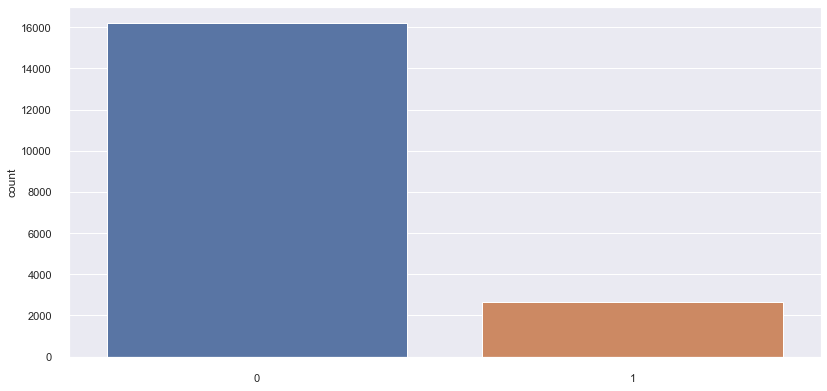

In [51]:
sns.countplot(x = y_train)
plt.show()

O valor `0` (indicando que o indivíduo **não possui conta bancária**) é quase 8 vezes maior que o valor `1`.
Portanto vamos aplicar a técnica de **Oversampling** e adicionaremos mais observações com valor igual `1`, caso contrário perderíamos muitas observações para treinar nosso modelo, o que não é recomendado.

## Resample

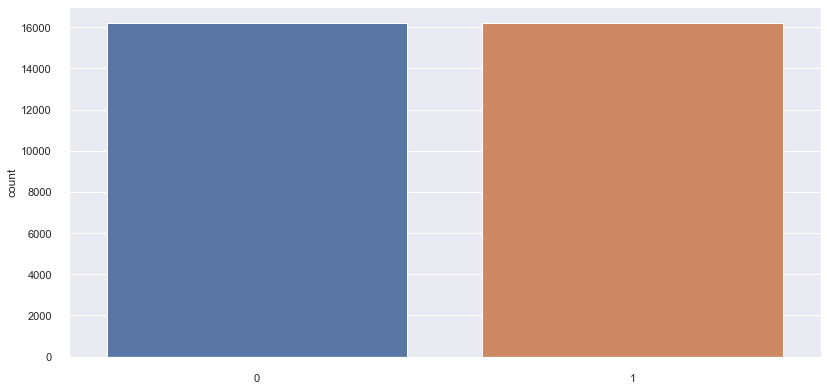

In [52]:
#oversample:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

#checando
sns.countplot(x= y_train)
plt.show()

Agora nosso dataset está balanceado, com a variável resposta igualmente distribuída.

É importante ressaltar que a técnica de balancemento deve ser feita **somente** no conjunto de treino para não "vazar" informações para o cojunto de teste e interferir na validação do nosso modelo.

# Building Models

### Dummy Classifier

In [53]:
#criando o classificador base line
dummy_clf = DummyClassifier(strategy = 'uniform', random_state = 1)

#training
dummy_clf.fit(X_train, y_train)

#predict
dummy_pred = dummy_clf.predict(X_test)

In [54]:
#Accuracy
accuracy_score(y_test, dummy_pred)

0.5062699256110521

In [55]:
# - AUC

dummy_probs = dummy_clf.predict_proba(X_test)

dummy_probs = dummy_probs[:, 1]

dummy_auc = roc_auc_score(y_test, dummy_probs)

print('Dummy: ROC AUC=%.3f' % (dummy_auc))

Dummy: ROC AUC=0.500


Vamos testar 3 modelos de classificação com seus parâmetros no *default* (sem customizar parâmetro nenhum) para vermos qual possui melhor desempenho. Em seguida, escolheremos o melhor entre eles para refinar os parâmetros. São eles:
- Regressão Logística
- Random Forest
- XGBOOST

Vamos criar um dataframe com as metricas dos modelos para mlehor visualização.

### Regressão Logística

**Treinando classificador**

In [56]:
#criando classificador
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

**Métricas no conjunto de treino**

In [57]:
#Metrics
logpred_train = logreg.predict(X_train)

#F1 Score:
f1_train = f1_score(y_train, logpred_train)

#ACC
acc_train = accuracy_score(y_train, logpred_train)

#AUC
train_proba = logreg.predict_proba(X_train)
train_proba = train_proba[:, 1]

train_auc = roc_auc_score(y_train, train_proba)

print('F1 Score = %.3f' % (f1_train))
print('Logistic Training Accuracy = %.3f' % (acc_train))
print('Logistic Training AUC = %.3f' % (train_auc))

F1 Score = 0.765
Logistic Training Accuracy = 0.774
Logistic Training AUC = 0.864


**Previsão no conjunto de testes**

In [58]:
logpred_test = logreg.predict(X_test)

**Métricas no conjunto de testes**

In [59]:
#F1 Score:
f1_test = f1_score(y_test, logpred_test)

#ACC
acc_test = accuracy_score(y_test, logpred_test)

#AUC
test_proba = logreg.predict_proba(X_test)
test_proba = test_proba[:, 1]

test_auc = roc_auc_score(y_test, test_proba)

print('F1 Score = %.3f' % (f1_test))
print('Logistic Test Accuracy = %.3f' % (acc_test))
print('Logistic Test AUC = %.3f' % (test_auc))

F1 Score = 0.491
Logistic Test Accuracy = 0.790
Logistic Test AUC = 0.830


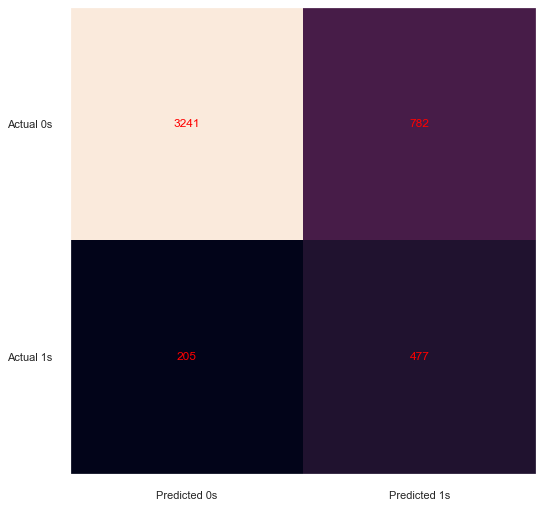

In [60]:
#matriz de confusão
cm = confusion_matrix(y_test, logpred_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

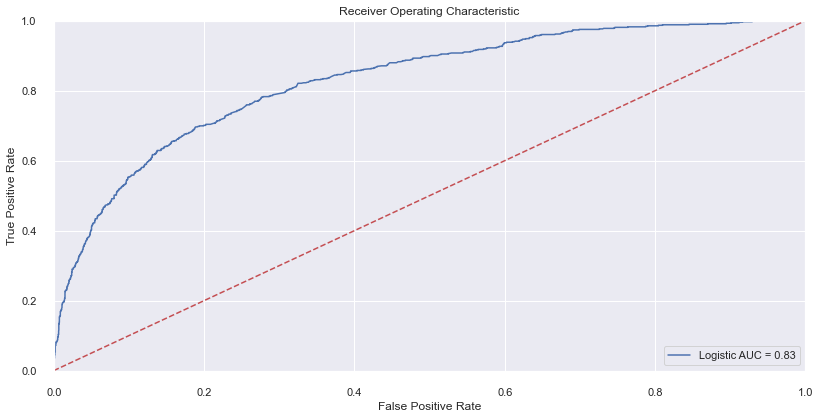

In [61]:
# AUC plot
lr_fpr, lr_tpr, threshold = roc_curve(y_test, test_proba)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic AUC = %0.2f' % lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
#armazenando as infos em um dataframe

d = {'modelo': ['Logistic Regression'], 'Train Accuracy': [acc_train], 'Train AUC': [train_auc],
     'Train F1 Score': [f1_train], 'Test Accuracy': [acc_test], 'Test AUC': [test_auc], 'Test F1 Score': [f1_test],
     'AUC_diff': [train_auc - test_auc]
    
    }

df_models = pd.DataFrame(data = d)
df_models.head()

,modelo,Train Accuracy,Train AUC,Train F1 Score,Test Accuracy,Test AUC,Test F1 Score,AUC_diff
0,Logistic Regression,0.773828,0.864046,0.764814,0.790223,0.829893,0.491499,0.034153


### Random Forest

**Treino**

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

#predict on training
rfpred_train = rf.predict(X_train)

**Métricas do treino**

In [64]:
#F1 Score:
f1_train = f1_score(y_train, rfpred_train)

#ACC
acc_train = accuracy_score(y_train, rfpred_train)

#AUC
train_proba = rf.predict_proba(X_train)
train_proba = train_proba[:, 1]

train_auc = roc_auc_score(y_train, train_proba)

print('F1 Score = %.3f' % (f1_train))
print('Logistic Training Accuracy = %.3f' % (acc_train))
print('Logistic Training AUC = %.3f' % (train_auc))

F1 Score = 0.913
Logistic Training Accuracy = 0.914
Logistic Training AUC = 0.978


**Teste**

In [65]:
#predict on test
rfpred_test = rf.predict(X_test)

**Métricas de teste**

In [66]:
#F1 Score:
f1_test = f1_score(y_test, rfpred_test)

#ACC
acc_test = accuracy_score(y_test, rfpred_test)

#AUC
test_proba = rf.predict_proba(X_test)
test_proba = test_proba[:, 1]

test_auc = roc_auc_score(y_test, test_proba)

print('F1 Score = %.3f' % (f1_test))
print('Logistic Test Accuracy = %.3f' % (acc_test))
print('Logistic Test AUC = %.3f' % (test_auc))

F1 Score = 0.463
Logistic Test Accuracy = 0.822
Logistic Test AUC = 0.796


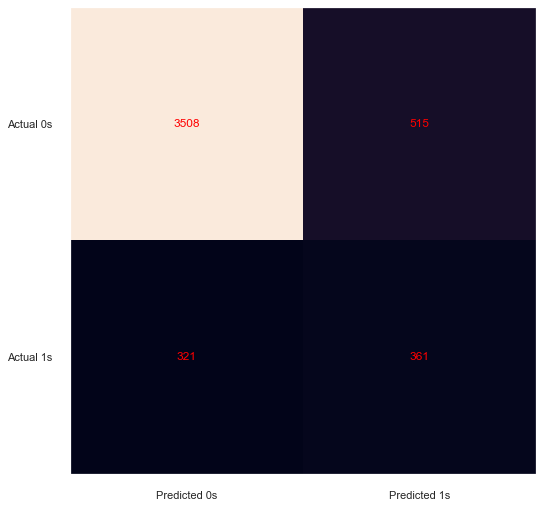

In [67]:
#matriz de confusão
cm = confusion_matrix(y_test, rfpred_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

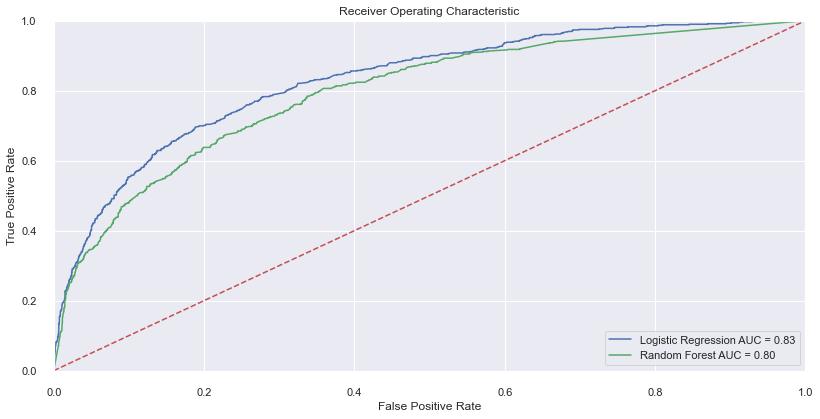

In [68]:
# AUC plot
rf_fpr, rf_tpr, threshold = roc_curve(y_test, test_proba)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
# add model values in dataframe
df_models.loc[1] = ['Random Forest', acc_train, train_auc, f1_train, 
                    acc_test, test_auc, f1_test, (train_auc - test_auc)]

df_models.head()

,modelo,Train Accuracy,Train AUC,Train F1 Score,Test Accuracy,Test AUC,Test F1 Score,AUC_diff
0,Logistic Regression,0.773828,0.864046,0.764814,0.790223,0.829893,0.491499,0.034153
1,Random Forest,0.913954,0.977909,0.913441,0.822317,0.796007,0.463415,0.181902


### XGBOOST

**Train**

In [70]:
xgbd = xgb.XGBClassifier()
xgbd.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
#predict
xgbd_train_pred = xgbd.predict(X_train)

**Métricas do treino**

In [72]:
#ACCURACY
xgbd_train_acc = accuracy_score(y_train, xgbd_train_pred)

#F1 Score:
xgbd_train_f1 = f1_score(y_train, xgbd_train_pred)

#AUC
xgbd_train_prob = xgbd.predict_proba(X_train)
xgbd_train_prob = xgbd_train_prob[:, 1]

xgbd_train_auc = roc_auc_score(y_train, xgbd_train_prob)

print('F1 Score = %.3f' % (xgbd_train_f1))
print('XGBoost Training Accuracy = %.3f' % (xgbd_train_acc))
print('XGBoost Training AUC = %.3f' % (xgbd_train_auc))

F1 Score = 0.877
XGBoost Training Accuracy = 0.879
XGBoost Training AUC = 0.957


**Teste**

In [73]:
#predict
xgbd_test_pred = xgbd.predict(X_test)

**Métricas no teste**

In [74]:
#ACCURACY
xgbd_test_acc = accuracy_score(y_test, xgbd_test_pred)

#F1 Score:
xgbd_test_f1 = f1_score(y_test, xgbd_test_pred)

#AUC
xgbd_test_prob = xgbd.predict_proba(X_test)
xgbd_test_prob = xgbd_test_prob[:, 1]

xgbd_test_auc = roc_auc_score(y_test, xgbd_test_prob)

print('F1 Score = %.3f' % (xgbd_test_f1))
print('XGBoost Test Accuracy = %.3f' % (xgbd_test_acc))
print('XGBoost Test AUC = %.3f' % (xgbd_test_auc))

F1 Score = 0.500
XGBoost Test Accuracy = 0.839
XGBoost Test AUC = 0.823


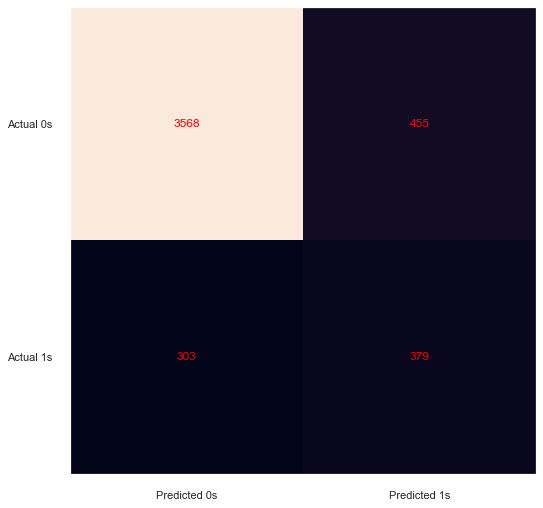

In [75]:
#matriz de confusão
cm = confusion_matrix(y_test, xgbd_test_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

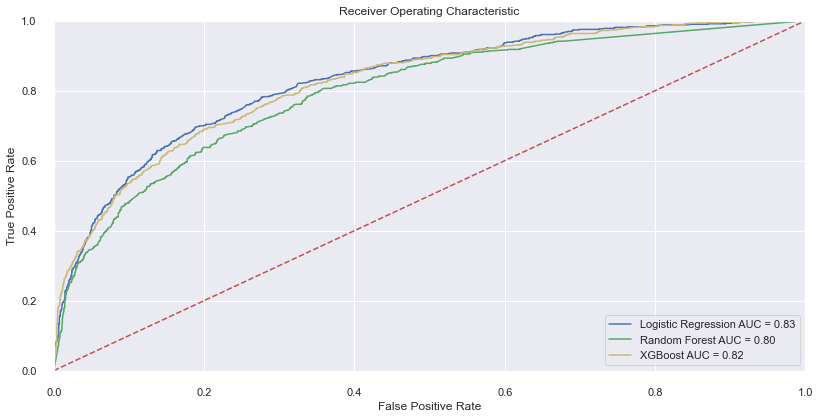

In [76]:
# AUC plot
xgbd_fpr, xgbd_tpr, threshold = roc_curve(y_test, xgbd_test_prob)
xgbd_roc_auc = metrics.auc(xgbd_fpr, xgbd_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.plot(xgbd_fpr, xgbd_tpr, 'y', label = 'XGBoost AUC = %0.2f' % xgbd_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
# add model values in dataframe
df_models.loc[2] = ['XGBOOST', xgbd_train_acc, xgbd_train_auc, xgbd_train_f1, 
                    xgbd_test_acc, xgbd_test_auc, xgbd_test_f1, (xgbd_train_auc - xgbd_test_auc)]

df_models.head()

,modelo,Train Accuracy,Train AUC,Train F1 Score,Test Accuracy,Test AUC,Test F1 Score,AUC_diff
0,Logistic Regression,0.773828,0.864046,0.764814,0.790223,0.829893,0.491499,0.034153
1,Random Forest,0.913954,0.977909,0.913441,0.822317,0.796007,0.463415,0.181902
2,XGBOOST,0.879363,0.957262,0.876751,0.838895,0.823254,0.500000,0.134008


### K-NN

**Treino**

In [78]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [79]:
#predict
knn_train_pred = knn.predict(X_train)

**Métricas no treino**

In [80]:
#ACCURACY
knn_train_acc = accuracy_score(y_train, knn_train_pred)

#F1 Score:
knn_train_f1 = f1_score(y_train, knn_train_pred)

#AUC
knn_train_prob = knn.predict_proba(X_train)
knn_train_prob = knn_train_prob[:, 1]

knn_train_auc = roc_auc_score(y_train, knn_train_prob)

print('F1 Score = %.3f' % (knn_train_f1))
print('K-NN Training Accuracy = %.3f' % (knn_train_acc))
print('K-NN Training AUC = %.3f' % (knn_train_auc))

F1 Score = 0.867
K-NN Training Accuracy = 0.868
K-NN Training AUC = 0.935


**Teste**

In [81]:
#predict
knn_test_pred = knn.predict(X_test)

**Métricas no Teste**

In [82]:
#ACCURACY
knn_test_acc = accuracy_score(y_test, knn_test_pred)

#F1 Score:
knn_test_f1 = f1_score(y_test, knn_test_pred)

#AUC
knn_test_prob = knn.predict_proba(X_test)
knn_test_prob = knn_test_prob[:, 1]

knn_test_auc = roc_auc_score(y_test, knn_test_prob)

print('F1 Score = %.3f' % (knn_test_f1))
print('K-NN Test Accuracy = %.3f' % (knn_test_acc))
print('K-NN Test AUC = %.3f' % (knn_test_auc))

F1 Score = 0.467
K-NN Test Accuracy = 0.804
K-NN Test AUC = 0.787


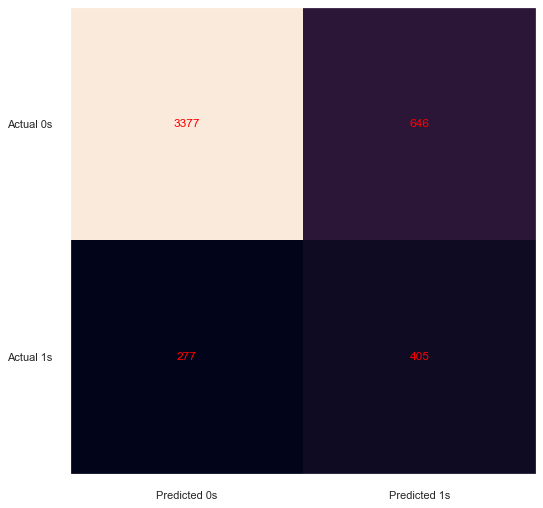

In [83]:
#matriz de confusão
cm = confusion_matrix(y_test, knn_test_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

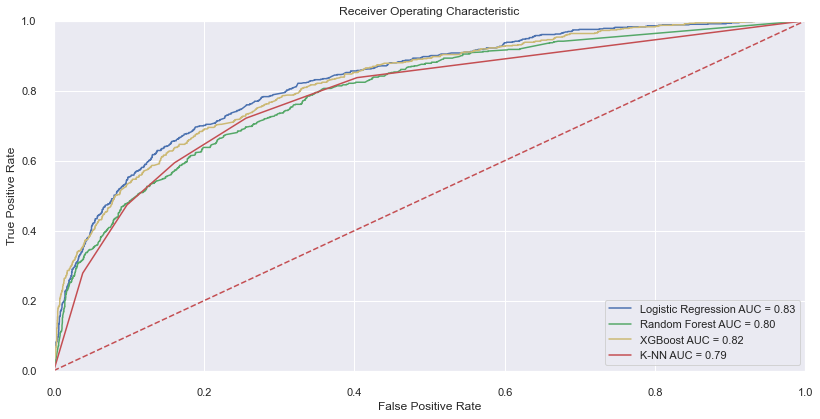

In [84]:
# AUC plot
knn_fpr, knn_tpr, threshold = roc_curve(y_test, knn_test_prob)
knn_roc_auc = metrics.auc(knn_fpr, knn_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.plot(xgbd_fpr, xgbd_tpr, 'y', label = 'XGBoost AUC = %0.2f' % xgbd_roc_auc)
plt.plot(knn_fpr, knn_tpr, 'r', label = 'K-NN AUC = %0.2f' % knn_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
# add model values in dataframe
df_models.loc[3] = ['K-NN', knn_train_acc, knn_train_auc, knn_train_f1, 
                    knn_test_acc, knn_test_auc, knn_test_f1, (knn_train_auc - knn_test_auc)]

df_models.head()

,modelo,Train Accuracy,Train AUC,Train F1 Score,Test Accuracy,Test AUC,Test F1 Score,AUC_diff
0,Logistic Regression,0.773828,0.864046,0.764814,0.790223,0.829893,0.491499,0.034153
1,Random Forest,0.913954,0.977909,0.913441,0.822317,0.796007,0.463415,0.181902
2,XGBOOST,0.879363,0.957262,0.876751,0.838895,0.823254,0.500000,0.134008
3,K-NN,0.867719,0.935269,0.866569,0.803826,0.786919,0.467398,0.148350


### Decision Tree

**Treino**

In [86]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [87]:
#predict
dt_train_pred = dt.predict(X_train)

**Métricas no treino**

In [88]:
#ACCURACY
dt_train_acc = accuracy_score(y_train, dt_train_pred)

#F1 Score:
dt_train_f1 = f1_score(y_train, dt_train_pred)

#AUC
dt_train_prob = dt.predict_proba(X_train)
dt_train_prob = dt_train_prob[:, 1]

dt_train_auc = roc_auc_score(y_train, dt_train_prob)

print('F1 Score = %.3f' % (dt_train_f1))
print('Decision Tree Training Accuracy = %.3f' % (dt_train_acc))
print('Decision Tree Training AUC = %.3f' % (dt_train_auc))

F1 Score = 0.913
Decision Tree Training Accuracy = 0.914
Decision Tree Training AUC = 0.980


**Métricas no teste**

In [89]:
dt_test_pred = dt.predict(X_test)

In [90]:
#ACCURACY
dt_test_acc = accuracy_score(y_test, dt_test_pred)

#F1 Score:
dt_test_f1 = f1_score(y_test, dt_test_pred)

#AUC
dt_test_prob = dt.predict_proba(X_test)
dt_test_prob = dt_test_prob[:, 1]

dt_test_auc = roc_auc_score(y_test, dt_test_prob)

print('F1 Score = %.3f' % (dt_test_f1))
print('Decision Tree Test Accuracy = %.3f' % (dt_test_acc))
print('Decision Tree Test AUC = %.3f' % (dt_test_auc))

F1 Score = 0.438
Decision Tree Test Accuracy = 0.817
Decision Tree Test AUC = 0.717


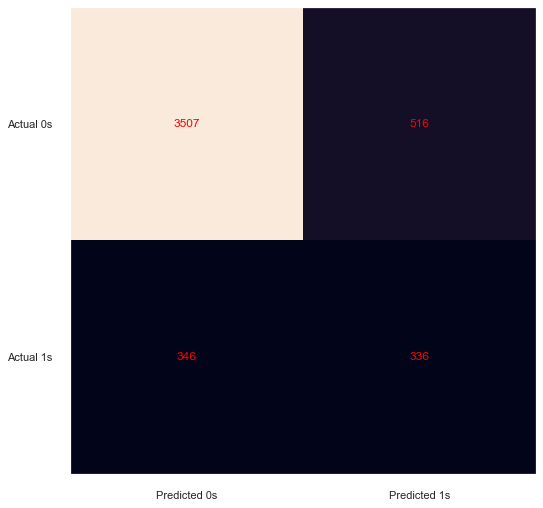

In [91]:
#matriz de confusão
cm = confusion_matrix(y_test, dt_test_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

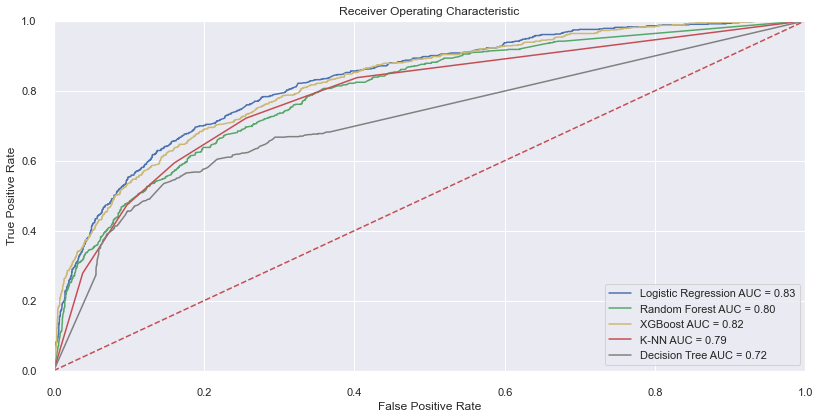

In [92]:
# AUC plot
dt_fpr, dt_tpr, threshold = roc_curve(y_test, dt_test_prob)
dt_roc_auc = metrics.auc(dt_fpr, dt_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.plot(xgbd_fpr, xgbd_tpr, 'y', label = 'XGBoost AUC = %0.2f' % xgbd_roc_auc)
plt.plot(knn_fpr, knn_tpr, 'r', label = 'K-NN AUC = %0.2f' % knn_roc_auc)
plt.plot(dt_fpr, dt_tpr, 'grey', label = 'Decision Tree AUC = %0.2f' % dt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
# add model values in dataframe
df_models.loc[4] = ['Decision Tree', dt_train_acc, dt_train_auc, dt_train_f1, 
                    dt_test_acc, dt_test_auc, dt_test_f1, (dt_train_auc - dt_test_auc)]

df_models.head()

,modelo,Train Accuracy,Train AUC,Train F1 Score,Test Accuracy,Test AUC,Test F1 Score,AUC_diff
0,Logistic Regression,0.773828,0.864046,0.764814,0.790223,0.829893,0.491499,0.034153
1,Random Forest,0.913954,0.977909,0.913441,0.822317,0.796007,0.463415,0.181902
2,XGBOOST,0.879363,0.957262,0.876751,0.838895,0.823254,0.500000,0.134008
3,K-NN,0.867719,0.935269,0.866569,0.803826,0.786919,0.467398,0.148350
4,Decision Tree,0.913954,0.980296,0.912621,0.816791,0.717459,0.438070,0.262838


Uma das métricas mais relevantes para validação de um modelo de classificação é a <a href = 'https://en.wikipedia.org/wiki/Receiver_operating_characteristic'> AUC</a> (*Area Under Curve*). No nosso caso o modelo de Regressão Logística teve um melhor desempenho com os parâmetros *default*. No entanto vamos utilizar também o XGBOOST para refinar os parâmetros, já que ele teve um AUC muito próximo do modelo de Regressão Logística. 

## Tuning Hyperparameter

### Logistic Regression

In [94]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fit_intercept = ['True']
max_iter = [1000,3000,5000]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values, fit_intercept=fit_intercept, max_iter=max_iter)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
logreg = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
logreg.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=1),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': ['True'],
                         'max_iter': [1000, 3000, 5000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [95]:
print("Best: %f using %s" % (logreg.best_score_, logreg.best_params_))

Best: 0.863766 using {'C': 1000, 'fit_intercept': 'True', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


**Test**

In [96]:
logreg_pred = logreg.predict(X_test)

In [97]:
#F1 Score:
logreg_f1 = f1_score(y_test, logreg_pred)

#ACC
logreg_acc = accuracy_score(y_test, logreg_pred)

#AUC
logreg_prob = logreg.predict_proba(X_test)
logreg_prob = logreg_prob[:, 1]

logreg_auc = roc_auc_score(y_test, logreg_prob)

print('F1 Score = %.3f' % (logreg_f1))
print('Logistic Regression Accuracy = %.3f' % (logreg_acc))
print('Logistic Regression AUC = %.3f' % (logreg_auc))

F1 Score = 0.491
Logistic Regression Accuracy = 0.790
Logistic Regression AUC = 0.829


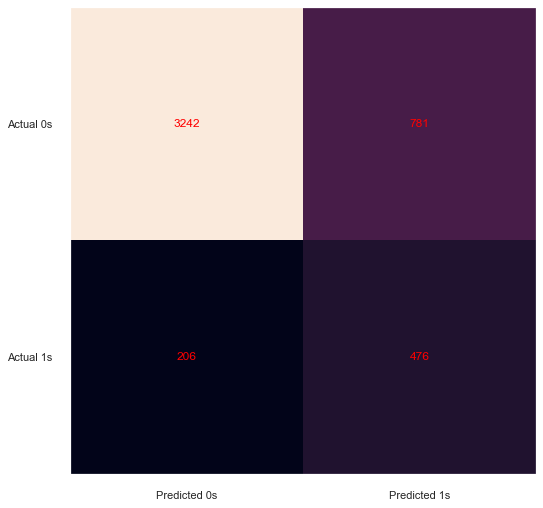

In [98]:
cm = confusion_matrix(y_test, logreg_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

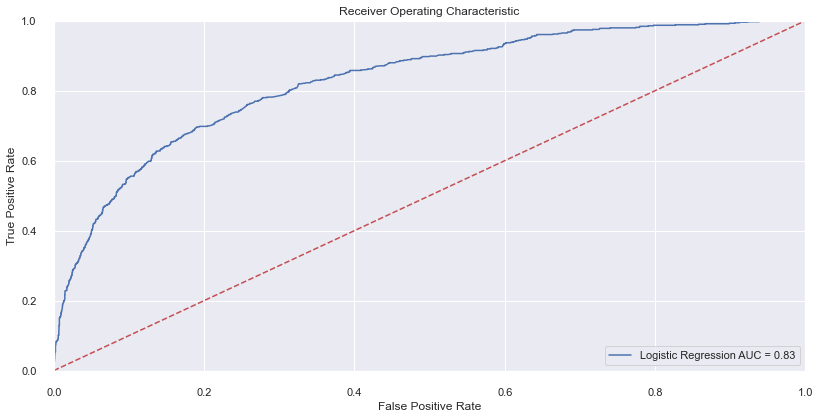

In [99]:
# AUC plot
lr_fpr, lr_tpr, threshold = roc_curve(y_test, logreg_prob)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

O modelo de Regressão Logística não obteve melhoria em comparação com os parâmetros default, embora um AUC de 0,85 seja muito bom.

### XGBOOST

**Tuning #1**

In [100]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)

In [101]:
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [102]:
#predict on test
xgb1_pred = xgb1.predict(X_test)

In [103]:
## Metrics

#F1 Score:
xgb1_f1 = f1_score(y_test, xgb1_pred)

#ACCURACY
xgb1_acc = accuracy_score(y_test, xgb1_pred)

#AUC
xgb1_prob = xgb1.predict_proba(X_test)
xgb1_prob = xgb1_prob[:, 1]

xgb1_auc = roc_auc_score(y_test, xgb1_prob)

print('F1 Score = %.3f' % (xgb1_f1))
print('XGBoost Accuracy = %.3f' % (xgb1_acc))
print('XGBoost AUC = %.3f' % (xgb1_auc))

F1 Score = 0.488
XGBoost Accuracy = 0.837
XGBoost AUC = 0.812


**Tuning #2**

In [104]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [105]:
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                                                  nthread=4, scale_pos_weight=1), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5)

In [106]:
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, subsample=0.8,
                                     tree_method=Non

In [107]:
#melhores parâmetros:
gsearch1.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [108]:
#AUC:
gsearch1.score(X_test, y_test)

0.8244622380257799

Neste segundo tunning já vimos uma boa melhora na nossa métrica em relação ao primeiro tunnin. Mas ainda não superamos o AUC de 0,84 do parâmetro default.

**Tuning #3**

Parâmetro de regularização (<a href = 'https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/'>alpha</a>). Ajuda a diminuir a complexidade do modelo e melhorar a performance.

In [109]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [110]:
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                                                  nthread=4, scale_pos_weight=1,
                                                    max_depth = 9, min_child_weight = 1), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1, cv=5)

In [111]:
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, subsample=0.8,
                                     tree_method=None, val

In [112]:
#melhores parâmetros:
gsearch2.best_params_

{'reg_alpha': 0.01}

In [113]:
#AUC:
gsearch2.score(X_test, y_test)

0.8252556961693138

vamos tentar melhorar utilizando alpha mais próximos de 0,01:

In [114]:
param_test3 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [115]:
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                                                  nthread=4, scale_pos_weight=1,
                                                    max_depth = 9, min_child_weight = 1), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1, cv=5)

In [116]:
gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, subsample=0.8,
                                     tree_method=None, val

In [117]:
#melhores parâmetros:
gsearch3.best_params_

{'reg_alpha': 0.01}

In [118]:
#AUC:
gsearch3.score(X_test, y_test)

0.8252556961693138

Não consgeuimos melhorar. O melhor parâmetro para alpha continua sendo 0,01.

Vamos para nossa última tentativa de refinar os parâmetros.

**Tuning#4**

Reduzir taxa de larning_rate e aumentar o n_estimators

In [119]:
xgb2 = xgb.XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000, 
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    max_depth = 9,
    min_child_weight = 1,
    reg_alpha = 0.01)

In [120]:
xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [121]:
#predict
xgb2_pred = xgb1.predict(X_test)

In [122]:
## Metrics

#F1 Score:
xgb2_f1 = f1_score(y_test, xgb2_pred)

#ACCURACY
xgb2_acc = accuracy_score(y_test, xgb2_pred)

#AUC
xgb2_prob = xgb2.predict_proba(X_test)
xgb2_prob = xgb2_prob[:, 1]

xgb2_auc = roc_auc_score(y_test, xgb2_prob)

print('F1 Score = %.3f' % (xgb2_f1))
print('XGBoost Accuracy = %.3f' % (xgb2_acc))
print('XGBoost AUC = %.3f' % (xgb2_auc))

F1 Score = 0.488
XGBoost Accuracy = 0.837
XGBoost AUC = 0.832


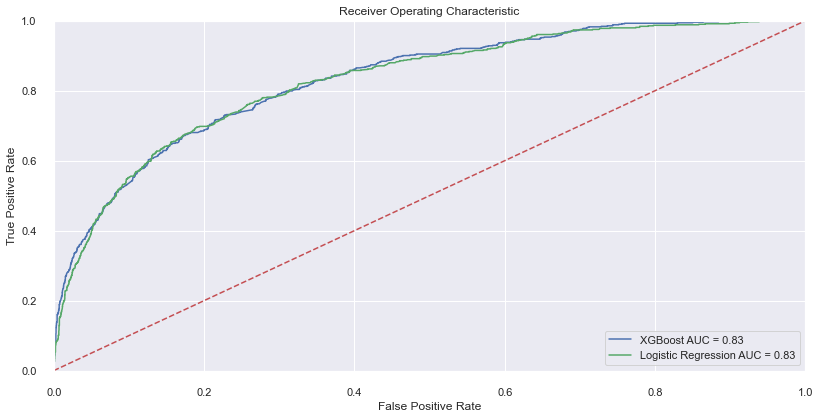

In [123]:
## AUC plot
xgb2_fpr, xgb2_tpr, threshold = roc_curve(y_test, xgb2_prob)
xgb2_roc_auc = metrics.auc(xgb2_fpr, xgb2_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(xgb2_fpr, xgb2_tpr, 'b', label = 'XGBoost AUC = %0.2f' % xgb2_roc_auc)
plt.plot(lr_fpr, lr_tpr, 'g', label = 'Logistic Regression AUC = %0.2f' % lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Conseguimos melhorar em um ponto percentual o AUC do XGBOOST, igulando assim ao modelo de Regressão Logística. 
Por possuir uma acurácia maior, o XGBOOST seria o mais adequado para utilização e implementação para nosso problema.